In [8]:
%matplotlib inline
########## DISABLE GPU
import sys
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from matplotlib import pyplot as plt
import numpy as np
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
sys.path.append("../vsegmenter")

from data.dataset import Dataset
from vsegmenter import cfg

cfg.configLog()

import logging

In [9]:
def plot_images(sample, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,20))
    
    ax[0].matshow(sample["image"]); ax[0].set_title(sample["filename"]); ax[0].axis('off')
    ax[1].matshow((sample["mask"]*255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
    ax[1].set_title(f"Extraction {sample['extraction']}"); ax[1].axis('off')
    ax[2].matshow((sample["prediction"]*255), cmap="gray", vmin=0, vmax=255) 
    ax[2].set_title(f"Predicted Mask {sample['count']}"); ax[2].axis('off')
    
def plot_image(sample):
    plt.figure()
    plt.imshow((sample*255).astype(np.uint8))
    

In [3]:
version = "v7"
img_size = 128

dataset_file = cfg.dataset(f'{version}/dataset_{img_size}.pickle')
x_train, y_train, x_val, y_val = Dataset.load_from_file(dataset_file)

# x_val = x_val[:20]
# y_val = y_val[:20]
x_val = x_train
y_val = y_train

print(f"Num samples: {len(y_val)}")


2023-05-10 22:20:50 INFO Number of train samples: 2331, test samples = 583
2023-05-10 22:20:50 INFO Sample dimensions: sample: (128, 128, 3) label (mask): (128, 128, 2)
2023-05-10 22:20:50 INFO Original image shape : (2331, 128, 128, 3)


Num samples: 2331


In [4]:
def to_255(image, random_state=None, parents=None, hooks=None):
    """Transformación personalizada para convertir una imagen de 0-1 a 0-255."""
    return np.round(image * 255).astype(np.uint8)

def to_1(image, random_state=None, parents=None, hooks=None):
    """Transformación personalizada para convertir una imagen de 0-255 a 0-1."""
    return image.astype(np.float32) / 255.

def binarize_mask(mask_arr):
    mask_arr[mask_arr < 128] = 0
    mask_arr[mask_arr > 128] = 255
    return mask_arr

def green_variation(image, random_state, parents, hooks):
    img = np.multiply(image, [1.0, np.random.uniform(0.95, 1.05), 1.0])
    return np.clip(img, 0, 255).astype(np.uint8)

In [82]:
# ia.seed(2)
seq = iaa.Sequential([
    iaa.Fliplr(0.5, random_state=1),
    iaa.Rot90((1, 3), random_state=2),
    iaa.Sometimes(
        0.5,iaa.Affine(scale={"x": (1, 1.3), "y": (1, 1.3)}, random_state=4), random_state=5),
    iaa.Sometimes(
        0.5,iaa.OneOf([
            iaa.Lambda(func_images=green_variation),
            iaa.GaussianBlur(sigma=(0, 0.5)),
            iaa.LinearContrast((0.85, 1.2)),
        ])
    ),    
], random_state=9)

seq_mask = iaa.Sequential([
    iaa.Fliplr(0.5, random_state=1),
    iaa.Rot90((1, 3), random_state=2),
    iaa.Sometimes(
        0.5,iaa.Affine(scale={"x": (1, 1.3), "y": (1, 1.3)}, random_state=4), random_state=5),
], random_state=9)

SyntaxError: invalid syntax (3155643801.py, line 10)

(array([ 4911,     0,     0,     0,     0,     0,     0,     0,     0,
       11473]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))
(array([ 5232,     0,     0,     0,     0,     4,     0,     0,     0,
       11148]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))


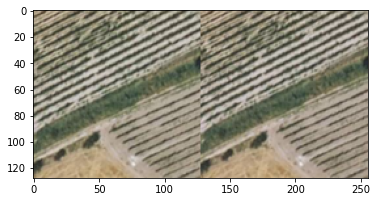

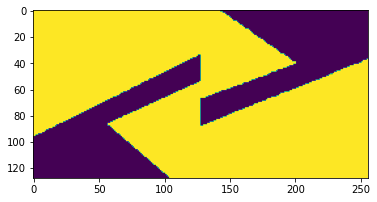

In [106]:
img_index = 17
img = to_255(x_val[img_index,:])
mask = to_255(y_val[img_index,:,:,1])
# plot_image(img)
image_aug = seq(image=img)
mask_aug = seq_mask(image=mask)
mask_aug = binarize_mask(mask_aug)

print(np.histogram(mask))
print(np.histogram(binarize_mask(mask_aug)))


plot_image(to_1(np.hstack([img, image_aug])))
plot_image(to_1(np.hstack([mask, mask_aug])))
# plt.imshow(img)

In [40]:
img.shape



(128, 128, 3)

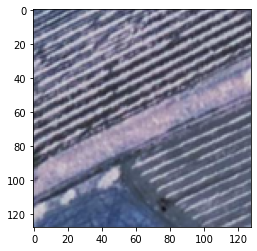

In [81]:
# Definir la transformación para variar un 10% el canal de verde
def img_func(image, random_state, parents, hooks):
    img = np.multiply(image, [1.0, np.random.uniform(0.95, 1.05), 1.0])
    return np.clip(img, 0, 255).astype(np.uint8)


green_variation = iaa.Lambda(img_func)

# Definir la secuencia de transformaciones
seq = iaa.Sequential([
    green_variation,
])

# np.multiply(images, [1.0, np.random.uniform(0.9, 1.1), 1.0])

plot_image(green_variation(image=img))

In [ ]:

seq = iaa.Sequential([
    iaa.Fliplr(0.5, random_state=1),
    iaa.Rot90((1, 3), random_state=2),
    iaa.Sometimes(
        0.5,iaa.Affine(scale={"x": (1, 1.3), "y": (1, 1.3)}, random_state=4), random_state=5),
    iaa.Sometimes(
        0.5,iaa.OneOf([
            iaa.GaussianBlur(sigma=(0, 0.5)),
            iaa.LinearContrast((0.85, 1.2)),
        ])
    ),    
], random_state=9)

seq_mask = iaa.Sequential([
    iaa.Fliplr(0.5, random_state=1),
    iaa.Rot90((1, 3), random_state=2),
    iaa.Sometimes(
        0.5,iaa.Affine(scale={"x": (1, 1.3), "y": (1, 1.3)}, random_state=4), random_state=5),
], random_state=9)


def apply_augmentation(image, mask):
    # Convertir la imagen a una matriz NumPy
    image = to_255(image.numpy())
    mask = to_255(mask.numpy())
    image_aug = seq(image=image)
    mask_aug = seq_mask(image=mask)
    mask_aug = binarize_mask(mask_aug)
    
    image_aug = tf.convert_to_tensor(to_1(image_aug))
    mask_aug = tf.convert_to_tensor(to_1(mask_aug))
    return image_aug, mask_aug

In [ ]:
from data.dataset import Dataset, create_tf_datasets
import tensorflow as tf





# Apply to tf dataset
train_dataset, validation_dataset = create_tf_datasets(x_train, y_train, x_val, y_val, batch_size=None)
train_dataset = train_dataset.map(lambda x, y: (tf.py_function(apply_augmentation, [x, y], [tf.float16, tf.uint8])))


In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_dataset.take(1).as_numpy_iterator().next()[0])
axs[1].imshow(train_dataset.take(1).as_numpy_iterator().next()[0])
plt.show()